# Income of unemployed family members

Key attributes:
- NQUEST: Numero di questionario, identificativo della famiglia
- NORD: Numero d'ordine del componente della famiglia

In [1]:
import os
import polars as pl
from BI_microdata_extractor import BIMicrodataExtractor

bfi = BIMicrodataExtractor()
bfi.load_data("BFI_2022")

In [15]:
bfi.attribute_categories

['investments',
 'opinion',
 'finance',
 'survey_keys',
 'bank_account',
 'survey_quality',
 'earnings',
 'digital',
 'labour_market',
 'capital_transfer',
 'transfer_income',
 'expenses',
 'credit',
 'other',
 'education',
 'demographics',
 'energy',
 'savings',
 'assets',
 'natural_disasters',
 None,
 'housing',
 'purchase_habits',
 'insurance',
 'transportation',
 'passive_income',
 'unemployment',
 'house_rental',
 'debt_and_loan']

In [ ]:
bfi.get_attribute_metadata("APQUAL2")

In [ ]:
_=bfi.get_attributes_by_categories("labour_market")

In [4]:
# Store in a list the family number (NQUEST) of all families where all members are unemployed
unemployed_fams = (
    bfi.df_familymembers
    .group_by("NQUEST")
    .agg([
        pl.col("B01").eq(2).all().alias("all_B01_eq_2")
    ])
    .filter(pl.col("all_B01_eq_2"))
    .select("NQUEST")
).to_series().to_list()


In [43]:
s=bfi.get_attributes_by_categories("transfer_income")

134 attributes matching the search criteria
Results for categories transfer_income:

n°   Attribute	Description
-----------------------------------------------------
B02  ASNONOC2:	Prima di essere pensionato o disoccupato che attività aveva?
B08  CONTRIB:	Considerando tutta la storia lavorativa, ha mai versato, o il datore di lavoro ha versato, anche per un breve periodo (anche lontano nel tempo) contributi per la pensione?
B09a  ACONTRIB:	Per quanti anni ha versato contributi (includendo anche quelli riscattati)?
B09b  FCONTRIB:	Di questi anni quanti sono riscattati o figurativi (per servizio militare, riscatto della laurea, mobilità, maternità, disoccupazione, CIG)?
B14  ETAPEN:	A che età prevede di andare (o è andato nel frattempo) in pensione?
B15  COPPU:	Pensi al momento in cui andrà/è andato in pensione e consideri solo la pensione pubblica, cioè escluda eventuali fondi pensione e pensioni integrative. Quale percentuale rappresenterà/rappresenta la pensione pubblica di rispetto a

In [ ]:
# Relevant attributes related to transfer income:
# B18, B19A, B19B, B19C APQUAL2==[11,12,13,14,15,16,17,21] RDC, AUU, TIPOPEN, DISD, ACED, APLD, BORSAD, RRD, ALIMD, ALTRED
# fmem fmem  fmem  fmem fmem                               fams fams B4       B5    B5    B5    B5      B5   B5     B5
# Età>=18 ("ANASC","<=",2003)

{1: 'Reddito di cittadinanza', 2: 'Pensione di cittadinanza', 3: 'Entrambi'}

In [ ]:
rules = [("ANASC","<=",2003),("B01","==",2)] # Unemployed adults
df_unempl = bfi.filter(rules, bfi.df_familymembers)

In [ ]:
bfi.get_attribute_metadata("APQUAL2")

In [29]:
df_unempl["APQUAL2"].value_counts().sort("APQUAL2")

APQUAL2,count
i64,u32
11,559
12,710
13,2240
14,29
15,5689
16,1007
17,1075
19,3
21,105


### Pensioni

In [ ]:
_=bfi.get_attribute_metadata("TIPOPEN",print_output=True)

In [ ]:
df_B4 = bfi.DFs["allb4"]
pen_count = df_B4["TIPOPEN"].value_counts().sort("TIPOPEN")

TIPOPEN,count
i64,u32
1,6212
2,213
3,921
4,85
5,555


### Reddito/pensione di cittadinanza (RDC/PDC)

In [ ]:
months_sum = pl.col("RDCMESI01")+pl.col("RDCMESI02")+pl.col("RDCMESI03")+pl.col("RDCMESI04")+pl.col("RDCMESI")+pl.col("RDCMESI")+pl.col("RDCMESI")+pl.col("RDCMESI")+pl.col("RDCMESI")+pl.col("RDCMESI")+pl.col("RDCMESI")+pl.col("RDCMESI")
df_RDC = bfi.df_families.filter(pl.col("PDC").is_in([1,2,3])).with_columns(pl.sum_horizontal(pl.col("^RDCMESI.*$")).alias("rdcmesi_sum").alias("RDC_tot_mesi"))

In [ ]:
# Number of months of RDC received by families
df_RDC["RDC_tot_mesi"]

RDC_tot_mesi
i64
2
10
12
1
12
…
12
12
5


### Indennità di disoccupazione, assistenza economica da amministraizoni pubbliche centrali/locali

In [ ]:
# DISD, ACED, APLD
df_B5 = bfi.DFs["allb5"]
sel = ["NQUEST","NORD", "DISD", "ACED", "APLD"]
df_indenn = df_B5.filter((pl.col("DISD")==1) | (pl.col("ACED")==1) | (pl.col("APLD")==1)).select(sel)
df_indenn

### Altre entrate

In [69]:
sel = ["NQUEST","NORD", "BORSAD", "RRD", "ALIMD", "ALTRED"]
df_B5.filter((pl.col("BORSAD")==1) | (pl.col("RRD")==1) | (pl.col("ALIMD")==1) | (pl.col("ALTRED")==1)).select(sel)

NQUEST,NORD,BORSAD,RRD,ALIMD,ALTRED
i64,i64,i64,i64,i64,i64
91079,3,1,2,2,2
512784,5,1,2,2,2
611412,3,1,2,2,2
611412,4,1,2,2,2
635112,1,2,2,2,1
…,…,…,…,…,…
1072846,1,2,2,2,1
1072846,2,1,2,1,2
1072846,3,1,2,1,2


In [ ]:
# Aggrego gli attributi di indennità e altre entrate da usare in seguito
df_B5_agg = df_B5.group_by("NQUEST").agg(pl.col("DISD"), pl.col("ACED"), pl.col("APLD"), pl.col("BORSAD"), pl.col("RRD"), pl.col("ALIMD"), pl.col("ALTRED"))
df_B5_agg

NQUEST,DISD,ACED,APLD,BORSAD,RRD,ALIMD,ALTRED
i64,list[i64],list[i64],list[i64],list[i64],list[i64],list[i64],list[i64]
35322,[null],[1],[2],[null],[null],[null],[null]
997979,"[null, null]","[null, null]","[null, null]","[2, 2]","[2, 1]","[1, 2]","[2, 2]"
1045266,[null],[2],[1],[null],[null],[null],[null]
682737,[null],[1],[2],[null],[null],[null],[null]
1019805,[1],[null],[null],[null],[null],[null],[null]
…,…,…,…,…,…,…,…
1041184,[null],[2],[1],[null],[null],[null],[null]
995559,[null],[null],[null],[1],[2],[2],[2]
1031296,[null],[1],[2],[null],[null],[null],[null]


### Famiglie senza membri occupati

In [ ]:
df_unemp_fams = (bfi.df_familymembers.group_by("NQUEST")
    .agg([
        (pl.col("B01") == 2).sum().alias("count_B01_eq_2"),
        pl.col("NCOMP").first().alias("NCOMP") 
    ])).filter(pl.col("count_B01_eq_2")==pl.col("NCOMP"))

df_familymembers_ = df_unemp_fams.join(df_B4, on=["NQUEST"], how="left")
df_unemp_familymembers = (
    df_familymembers_
    .group_by("NQUEST")
    .agg([
        pl.col("count_B01_eq_2").first(),  # already aggregated, just retain
        pl.col("NCOMP").first(),           # already aggregated, just retain
        pl.col("TIPOPEN").alias("TIPOPEN") # list of distinct values
    ])
)

In [130]:
df_unemp_familymembers

NQUEST,count_B01_eq_2,NCOMP,TIPOPEN
i64,u32,i64,list[i64]
935077,2,2,"[1, 1]"
1030683,2,2,"[1, 1]"
687018,1,1,"[1, 3]"
1032434,1,1,[1]
990648,1,1,[1]
…,…,…,…
1001833,2,2,"[1, 2]"
1015570,2,2,"[1, 1]"
1065853,3,3,"[1, 2]"


In [ ]:
df_unemp_familymembers_ = df_unemp_familymembers.join(bfi.df_families,on="NQUEST",how="left").select(["NQUEST","count_B01_eq_2", "NCOMP", "TIPOPEN", "RDC", "AUU"])
df_unemp_familymembers_ = df_unemp_familymembers_.join(df_B5_agg,on="NQUEST",how="left")
# Drop famiglie con solo pensionati
# df_unemp_familymembers_ = df_unemp_familymembers_.filter(pl.col("TIPOPEN").list.len() < pl.col("NCOMP"))
df_unemp_familymembers_

NQUEST,count_B01_eq_2,NCOMP,TIPOPEN,RDC,AUU,DISD,ACED,APLD,BORSAD,RRD,ALIMD,ALTRED
i64,u32,i64,list[i64],i64,i64,list[i64],list[i64],list[i64],list[i64],list[i64],list[i64],list[i64]
935077,2,2,"[1, 1]",2,null,null,null,null,null,null,null,null
1030683,2,2,"[1, 1]",2,null,null,null,null,null,null,null,null
687018,1,1,"[1, 3]",2,null,null,null,null,null,null,null,null
1032434,1,1,[1],2,null,null,null,null,null,null,null,null
990648,1,1,[1],2,null,null,null,null,null,null,null,null
1029650,2,2,[1],2,null,null,null,null,null,null,null,null
1045650,1,1,"[1, 3]",2,null,null,null,null,null,null,null,null
930712,2,2,"[1, 1]",2,null,null,null,null,null,null,null,null
956558,2,2,"[1, 1]",2,null,null,null,null,null,null,null,null


In [435]:
df_unemp_familymembers_ = df_unemp_familymembers_.with_columns(
        pl.col("RDC").is_in([1]),
        pl.col("AUU").is_in([1]),
    )

In [444]:
# Somma i valori "1" nelle seguenti colonne:
cols = ["DISD", "ACED", "APLD", "BORSAD", "RRD", "ALIMD", "ALTRED"]
df = df_unemp_familymembers_
for col in cols:
    df = df.with_columns(
        pl.when(pl.col(col).list.eval(pl.element().is_not_null()).list.sum() == 0)
        .then(None)
        .otherwise(
            pl.col(col)
            .list.eval(pl.element() == 1)
            .list.sum()
        )
        .alias(col)
    )

# Sostituisce il tipo di pensione con il numero di pensioni nella famiglia
df = df.with_columns(
    pl.col("TIPOPEN")
    .list.eval(pl.element().is_not_null())
    .list.sum()
    .alias("NPEN")
).drop(["count_B01_eq_2","NCOMP","TIPOPEN"])

In [445]:
df

NQUEST,RDC,AUU,DISD,ACED,APLD,BORSAD,RRD,ALIMD,ALTRED,NPEN
i64,bool,bool,u32,u32,u32,u32,u32,u32,u32,u32
935077,false,null,null,null,null,null,null,null,null,2
1030683,false,null,null,null,null,null,null,null,null,2
687018,false,null,null,null,null,null,null,null,null,2
1032434,false,null,null,null,null,null,null,null,null,1
990648,false,null,null,null,null,null,null,null,null,1
1029650,false,null,null,null,null,null,null,null,null,1
1045650,false,null,null,null,null,null,null,null,null,2
930712,false,null,null,null,null,null,null,null,null,2
956558,false,null,null,null,null,null,null,null,null,2


In [446]:
cols_to_check = [col for col in df.columns if col != "NQUEST"]

# Build a list of conditional expressions: if not null, return column name
df = df.with_columns(
    pl.concat_list([
        pl.when((pl.col(c).is_not_null()) & (pl.col(c) != False))
        .then(pl.lit([c]))
        .otherwise(pl.lit([]))
        for c in cols_to_check
    ]).alias("income_from")
)

In [447]:
df = df.with_columns(pl.col("income_from").list.join(", ").alias("income_from"))

In [448]:
df["income_from"].value_counts()

income_from,count
str,u32
"""RRD, ALTRED""",3
"""RDC, APLD, BORSAD, ALIMD, ALTR…",1
"""APLD, NPEN""",16
"""RDC, ALTRED, NPEN""",1
"""AUU, ALIMD""",1
"""ALTRED""",2
"""AUU, DISD, ACED, NPEN""",1
"""ALIMD""",5
"""RDC, ACED""",14


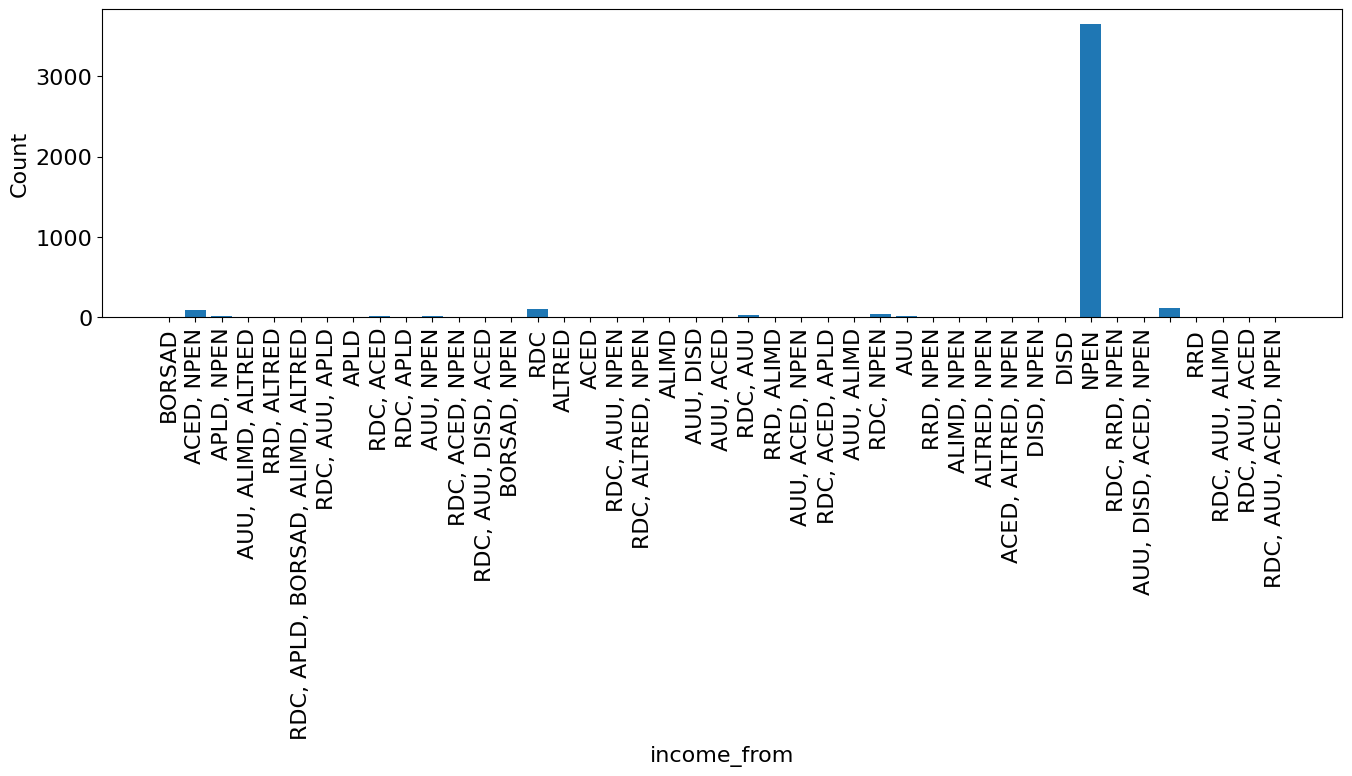

In [450]:
import matplotlib.pyplot as plt

# Convert to pandas
df_pd = df["income_from"].value_counts().to_pandas()

# Plot
plt.figure(figsize=(16, 4))
plt.bar(df_pd["income_from"], df_pd["count"])
plt.xlabel("income_from")
plt.ylabel("Count")
# plt.title("Value Counts Distribution")
plt.xticks(rotation='vertical')
plt.show()


In [452]:
print("percentage of families without employed memebers in the survey:")
round(df_unemp_familymembers_.__len__()/bfi.df_families.__len__(),3)

percentage of families without employed memebers in the survey:


0.436

In [108]:
bfi.df_families.filter(pl.col("NQUEST") == 925496)

NQUEST,TIPOI,QUEST,NQUESTP,STUPCF,STUMCF,STUPCO,STUMCO,CITPCF,CITMCF,CITPCO,CITMCO,VITGEN,NGEN,FIGLI,NFIGLI,PARNOIT,ANCONV,CONTINT,pesofit,NCOMP,NPERL,NPERC,NEQU,RDC,RDCMESI01,RDCMESI02,RDCMESI03,RDCMESI04,RDCMESI05,RDCMESI06,RDCMESI07,RDCMESI08,RDCMESI09,RDCMESI10,RDCMESI11,RDCMESI12,…,MKSWC,ENREACT1,ENREACT2,ENREACT3,ENREACT4,ENINVEST,ENINVESTCOME,RITBOL,ASPINF2A,ASPINF2B,DOCSEZE,ASS2NEW1,ASS2NEW2,ASS2NEW3,ASS2NEW4,ASS2NEW5,ASS2NEW6,ASS1NEW1,ASS1NEW2,ASS1NEW3,ASS1NEW4,ASS1NEW5,ASS1NEW6,ASS4,ASS4S,ASS32,ASS3S2,DOCSEZF,COMPRENS,ITA,VEROAF,VEROAB,VERORED,KLIMA,FACIL,INTS,DURATA
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
925496,1,3,null,null,null,null,null,null,null,null,null,2,null,1,2,2,null,1,0.41226,2,0,1,1.5,2,null,null,null,null,null,null,null,null,null,null,null,null,…,4,1,7,8,null,2,null,1,9.0,null,2,2,2,null,null,null,null,2,2,null,null,null,null,2,null,2,null,2,9,9,8,9,9,9,8,9,32


In [322]:
_=bfi.get_attribute_metadata("TIPOPEN",print_output=True)

Attribute:
   TIPOPEN
Description:
   Tipo di pensione percepita nel 2022
Encod.	Label
1	da lavoro (previdenziale)
2	sociale (assistenziale ad esclusione della pensione di cittadinanza)
3	di reversibilità
4	complementare/integrativa (contrib. volontaria) o da assicurazioni private
5	altro (pensione di inabilità/invalidità, pensione di guerra, etc…)


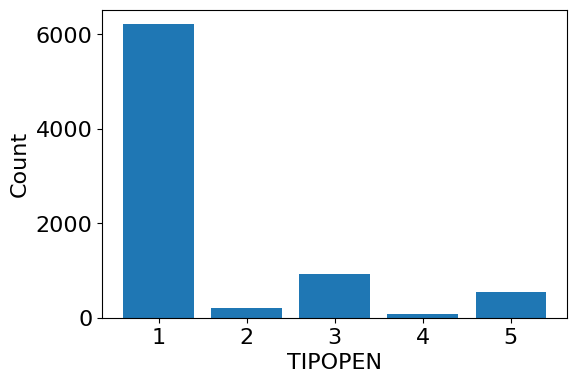

In [453]:
df_B4["TIPOPEN"].unique()
import matplotlib.pyplot as plt

# Convert to pandas
df_pd = df_B4["TIPOPEN"].value_counts().to_pandas()

# Plot
plt.figure(figsize=(6, 4))
plt.bar(df_pd["TIPOPEN"], df_pd["count"])
plt.xlabel("TIPOPEN")
plt.ylabel("Count")
# plt.title("Value Counts Distribution")
# plt.xticks(rotation='vertical')
plt.show()


In [295]:
bfi.df_familymembers

NQUEST,NCOMP,nord,SEX,PARENT,NASC,ANASC,CIT,ANINGR,MOTIV,STACIV,STUDIO,TIPOLAU,VOTOEDU,SUEDU,SELODE,ANNOEDU,TIPODIP,PRESNORD,NORDP,MOTENT,ANNOENUS,B01,APQUAL2,ASNONOC2,NACE2,NESPLAV,ETALAV,DISLAV,DISANN1,DISANN2,CONTRIB,ACONTRIB,FCONTRIB,OCCNOW,SALMIN,SALMIN1,SMARTW2,SMARTWB,ETAPEN,COPPU,B16,B17A,B17B,B17C,B18,B19A,B19B,B19C,ATTIVP,ISCO,NACE,ETALAV2,NASCAREA,NASCREG,IREG,ETA,CLETA5,QUAL,Q,SETT,CFRED,PERC,PERL,NPERL,NPERC,AREA3,AREA5,ACOM4C,ACOM5,pesofit,pesofit2
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64
173,1,1,1,1,1,1948,1,null,null,3,5,null,44.0,60,null,1968,2,1,1,null,null,2,15,2,10,1,27,2,null,null,1,33,0,2,null,null,null,null,null,null,2,2,2,2,1,2,2,2,null,0,null,null,3,18,18,74,5,6,3,5,1,1,0,0,1,3,4,2,4,0.226393,588.394267
2886,2,1,1,1,1,1949,1,null,null,1,5,null,37.0,60,null,1970,2,1,1,null,null,2,15,2,16,1,26,2,null,null,1,35,0,2,null,null,null,null,null,null,2,2,2,2,1,2,2,2,null,0,null,null,3,13,13,73,5,6,3,5,0,1,0,0,2,3,4,2,3,0.051872,134.814571
2886,2,2,2,3,1,1952,1,null,null,1,6,3,110.0,110,1,2000,5,1,2,null,null,2,15,2,17,1,22,2,null,null,1,44,0,2,null,null,null,null,null,null,2,2,2,2,1,2,2,2,null,0,null,null,3,13,13,70,5,6,3,5,1,1,0,0,2,3,4,2,3,0.051872,134.814571
3717,1,1,2,1,1,1954,1,null,null,2,4,null,null,null,null,null,null,1,1,null,null,2,16,null,null,0,null,null,null,null,null,null,null,2,null,null,null,null,null,null,2,2,2,2,1,2,2,2,null,0,null,null,3,16,16,68,5,6,3,5,1,1,0,0,1,3,4,2,4,0.262155,681.340514
5416,3,1,2,1,1,1958,1,null,null,3,3,null,null,null,null,null,null,1,1,null,null,2,15,1,9,3,16,2,null,null,1,30,0,2,null,null,null,null,null,null,2,2,2,2,1,2,2,2,null,0,null,null,3,20,8,64,4,6,3,5,1,1,0,2,3,1,2,2,4,0.320193,832.180346
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1072961,5,4,1,6,1,2016,1,null,null,2,1,null,null,null,null,null,null,null,null,null,null,2,17,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2,null,2,2,null,0,null,null,3,20,20,6,1,7,3,5,0,0,0,1,3,3,5,0,1,2.602902,6764.931836
1072961,5,5,1,6,1,2020,1,null,null,2,1,null,null,null,null,null,null,null,null,null,null,2,18,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2,null,2,2,null,0,null,null,3,20,20,2,1,7,3,5,0,0,0,1,3,3,5,0,1,2.602902,6764.931836
1072969,1,1,2,1,1,1946,1,null,null,4,3,null,null,null,null,null,null,1,null,null,null,2,16,null,null,1,40,2,null,null,2,null,null,2,null,null,null,null,null,null,2,2,2,2,1,2,2,2,null,0,null,null,2,11,11,76,5,6,3,5,1,1,0,0,1,2,3,2,4,0.826032,2146.854804


### Percentage of unemployment in Italy

In [ ]:
# bfi.df_familymembers = bfi.df_familymembers.with_columns(pl.col("nord").alias("NORD"))
pensionati = df_B4.filter(pl.col("TIPOPEN").is_in([1,2,5]))

# Filter family members in working age and conditions
df_unempl = bfi.df_familymembers.join(pensionati, on=["NQUEST","NORD"], how="anti").filter((pl.col("B01")==2) & (pl.col("ANASC")<2003) & (pl.col("ANASC")>1957) & (pl.col("APQUAL2")!=17) & (pl.col("APQUAL2")!=16))

print("Tasso di Disoccupazione \nIstat 2022:    7.8 %")
print("Da sondaggio: ",round(df_unempl.__len__()/bfi.df_familymembers.__len__()*100,1),"%")

Tasso di Disoccupazione 
Istat 2022:    7.8 %
Da sondaggio:  11.7 %


In [323]:
_=bfi.get_attribute_metadata("APQUAL2",print_output=True)

Attribute:
   APQUAL2
Description:
   Qualifica occupazione
Encod.	Label
1	operaio o posizione similare (inclusi salariati e apprendisti, lavoranti a domicilio, commessi)
2	impiegato
3	insegnante di qualunque tipo di scuola (inclusi incaricati, contrattisti e simili)
4	impiegato direttivo/quadro
5	dirigente, alto funzionario, preside, direttore didattico, docente universitario, magistrato
6	libero professionista
7	imprenditore individuale
8	lavoratore in proprio (ad es. artigiano)
9	titolare, socio-gestore di una società o di una cooperativa
10	 coadiuvante (non alle dipendenze) nella ditta di un familiare convivente
11	in cerca di prima occupazione
12	disoccupato
13	casalinga/o
14	benestante
15	pensionato da lavoro
16	pensionato non da lavoro (invalidità/reversibilità/sociale)
17	studente (dalla prima elementare in poi)
18	bambino in età prescolare
19	volontario
20	lavoratore atipico (lavoro parasubordinato, collaborazioni occasionali, lavoro accessorio, coadiuvante non alle dipendenz